<a href="https://colab.research.google.com/github/Asad1287/SimpySimulations/blob/main/War_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ukraine conflict has recently renewed interest in war, one of most important question when dealing with battle scearnios is calculation of force concentraiton requirements. "Force multiplier" have become a buzzword nowdays and is applied to any sort of capital intensive hardware purchase by an opposing side. There have been a plethora of stuides staring with Lancaster Laws from first world ware to mordern high powered discerte event simulations. In this article lets build very simiple simulation to simulate two opposing armies one attacker and one defender. Obviously I will not be including complex impacts like troops morale and battlefield logistics, hence the models might be more relevant to pre mordern engangnements where numbers mattered a lot. Lets determine the number of soldiers needed to capture enemy castle given Na numbers of attackers and Nd numbers of defenders and obviously defenerder have additional firepower and defense advantage

In [40]:
#Question #1 how many soldiers to bring on battle field
#Lets assume attacker army has  firepower of c1 and opposing side has firepower of c2, since defender is well-entrenced lets assume c2>c1. Also lets assume c3 is the chance that POW will be captured and used by defender
# Probalbity (defender , attacker ) = c1*Probalbity (defender , attacker - 1 ) + c2*Probalbity (defender - 1 , attacker ) + c3*Probalbity (defender+ 1 , attacker - 1 ) , we can create a recurssion function

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import collections
import functools
import random
# lets assume c2 is double that of c1
global c1
c1 = 0.3
global c2 
c2 = 0.6
global c3 
c3 = 0.1
c2 = 1 - c1 -c3
cache = functools.lru_cache(None)
sys.setrecursionlimit(50000)
def attacker_needed(defender:int,  p:float=0.70,c1:float=0.3) -> int:
    
    return next(a for a in range(1, sys.maxsize) if P_attacker_win(defender, a,c1,c2,c3) >= p)

@cache#@Cache2d(12000, 12000)
def P_attacker_win(defender:int, attacker:int,c1:int,c2:int,c3:int) -> float:
    
    return (1 if not defender else
            0 if not attacker else
            c1*(P_attacker_win(defender - 1, attacker,c1,c2,c3)) + c2*P_attacker_win(defender, attacker - 1,c1,c2,c3) + c3*P_attacker_win(defender+1, attacker - 1,c1,c2,c3))

print(P_attacker_win(10,10,c1,c2,c3)*100)
#with 10 attacker and 10 defender attackers have 1.83% chance on random 



1.8306794607669103


lets 

In [41]:
#lets fit these to a polynomial , Y - attacker army , X - defender army 

from typing import List
def best_fit_quadratic(X:List[float], Y:List[float]) -> List[float]:
    "Best-fit second-degree polynomial for X, Y points."
    a, b, c = np.polyfit(X, Y, 2)
    f = lambda x: a*x**2 + b*x + c
    err = max(abs(f(x) - y) for x, y in zip(X, Y))
    f.__doc__ = f'{a:.3f}d^2 {b:+.3f}d {c:+.3f} (±{err:.1f})'
    return f

D = range(1,10)
print(f'for 1 to 10 defenders we will need {[attacker_needed(d) for d in D]} numbers of attackers')
print(best_fit_quadratic(D, [attacker_needed(d) for d in D]).__doc__)


for 1 to 10 defenders we will need [5, 9, 13, 18, 22, 26, 30, 34, 38] numbers of attackers
-0.029d^2 +4.442d +0.381 (±0.4)


Lets create a simple function for this 

In [44]:
def show(D):
      for d in D:
          a = attacker_needed(d)
          f = best_fit_quadratic(range(1, d + 1), [attacker_needed(d) for d in range(1, d + 1)])
          print(f'P({d:3}, {a:5}) = {P_attacker_win(d, a,c1,c2,c3):.2%} | a = {f.__doc__}')
show(range(10, 101, 10))

P( 10,    42) = 70.82% | a = -0.027d^2 +4.419d +0.417 (±0.4)
P( 20,    81) = 70.64% | a = -0.014d^2 +4.286d +0.669 (±0.5)
P( 30,   119) = 70.50% | a = -0.008d^2 +4.173d +1.050 (±0.6)
P( 40,   157) = 70.85% | a = -0.005d^2 +4.083d +1.467 (±0.7)
P( 50,   194) = 70.58% | a = -0.004d^2 +4.042d +1.717 (±0.8)
P( 60,   231) = 70.52% | a = -0.003d^2 +4.002d +2.004 (±1.0)
P( 70,   268) = 70.59% | a = -0.003d^2 +3.966d +2.313 (±1.3)
P( 80,   304) = 70.09% | a = -0.002d^2 +3.941d +2.554 (±1.5)
P( 90,   341) = 70.32% | a = -0.002d^2 +3.918d +2.808 (±1.7)
P(100,   378) = 70.58% | a = -0.002d^2 +3.895d +3.083 (±2.0)


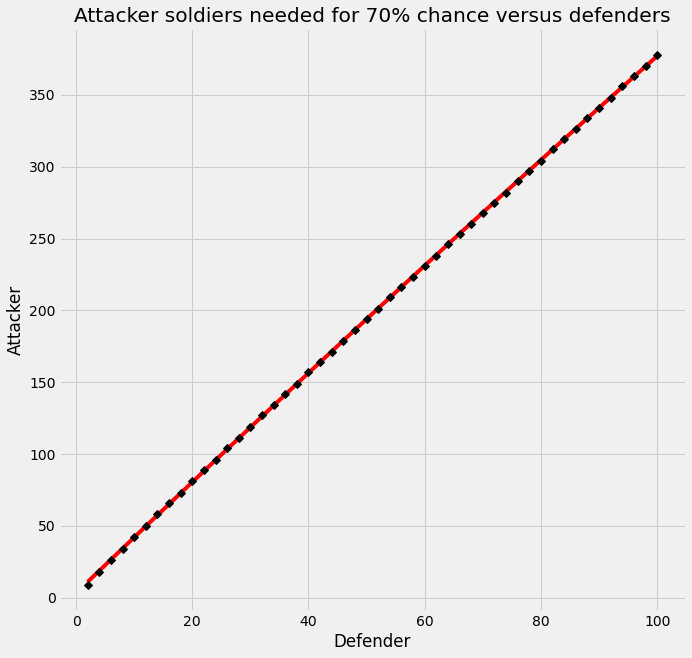

In [45]:
def plot_needed(D):
    "Plot the number of attacking soldiers needed for a 70% chance to defeat the defender."
    A = [attacker_needed(d) for d in D]
    plt.xlabel('Defender'); plt.ylabel('Attacker')
    plt.title('Attacker soldiers needed for 70% chance versus defenders')
    f = best_fit_quadratic(D, A)
    plt.plot(D, [f(d) for d in D], 'r-')
    plt.plot(D, A, 'kD')

plt.rcParams["figure.figsize"] = [10, 10]
plt.style.use('fivethirtyeight')
plt.grid(True); 

plot_needed(range(2, 101, 2))

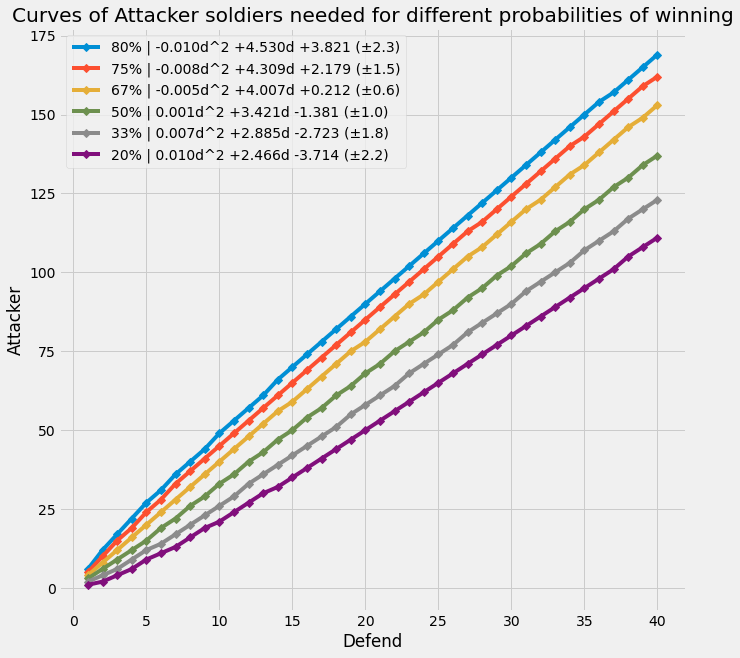

In [46]:
def contours(D=range(1, 41), probs=[4/5, 3/4, 2/3, 1/2, 1/3, 1/5]):
    
    for p in probs:
        A = [attacker_needed(d, p) for d in D]
        plt.plot(D, A, 'D-', label=f'{p:.0%} | {best_fit_quadratic(D, A).__doc__}')
    plt.legend(); plt.xlabel('Defend'); plt.ylabel('Attacker')
    plt.title('Curves of Attacker soldiers needed for different probabilities of winning')

contours()

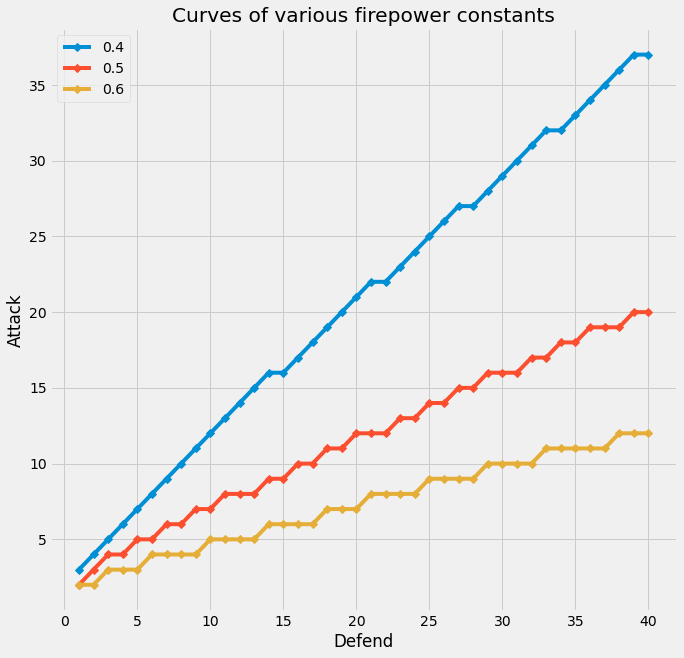

In [47]:
def Impact_of_Firepower(D=range(1, 41), c1=[0.4,0.5,0.6]):
    
    for c in c1:
        A = [attacker_needed(d, c1=c) for d in D]
        plt.plot(D, A, 'D-', label=f'{c}')
    plt.legend(); plt.xlabel('Defend'); plt.ylabel('Attack')
    plt.title('Curves of various firepower constants')
Impact_of_Firepower()

# Who will win the battle 

In [49]:
ProbDist = collections.Counter

@cache
def remains(defender, attacker,  weight=1.0):
    "What is the probability distribution over remaining soldiers? (Negative numbers are defenders soldiers.)"
    return (ProbDist({attacker: weight}) if not defender else
            ProbDist({-defender: weight}) if not attacker else
            remains(defender - 1, attacker, weight *0.3 ) + remains(defender , attacker - 1, weight * 0.6))

  

def plot_remains(pairs):
    "Show how many soldiers remain at the end of each (a, d) battle."
    for d, a in pairs:
        P = remains(d, a)
        plt.plot(sorted(P), [P[x] for x in sorted(P)], 'o-', 
                 label=f'{P_attacker_win(d, a,c1,c2,c3):.0%}, {mean(P):+.1f} for {d} v. {a}')
    plt.legend(); plt.xlabel('Outcome'); plt.ylabel('Probability')
    plt.title(f'Battle outcomes')
    
def mean(P): return sum(x * P[x] for x in P)
remains(1, 2)

Counter({2: 0.3, 1: 0.18, -1: 0.36})

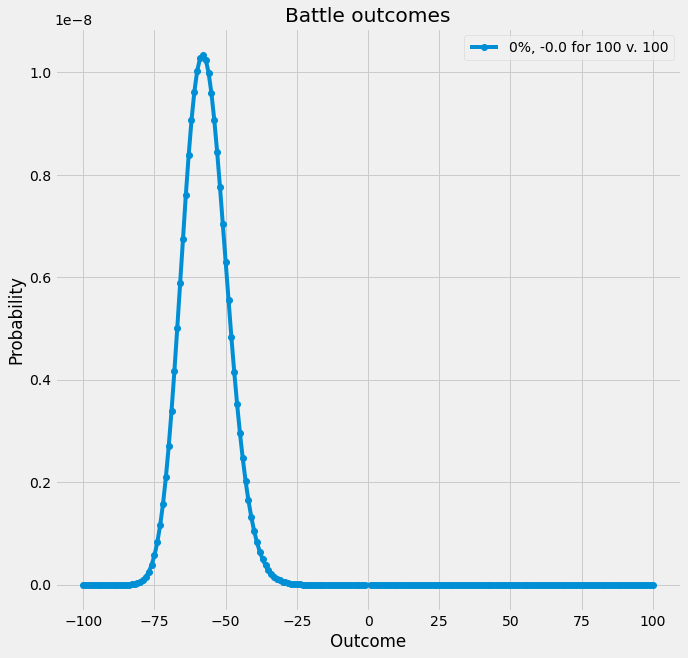

In [50]:
plot_remains([(100, 100)])


In [52]:
#probablitlic scenarios
def P_attacker_win_function(defender:int, attacker:int):
  c1 = random.uniform(0.3,0.4)
  c2 = random.uniform(0.5,0.6)
  c3 = 0.1
  def P_attacker_win(defender:int, attacker:int,c1:int,c2:int,c3:int) -> float:
    
      return (1 if not defender else
              0 if not attacker else
              c1*(P_attacker_win(defender - 1, attacker,c1,c2,c3)) + c2*P_attacker_win(defender, attacker - 1,c1,c2,c3) + c3*P_attacker_win(defender+1, attacker - 1,c1,c2,c3))
  
  
  return P_attacker_win(defender, attacker,c1,c2,c3)

P_attacker_win_function(4,10)


0.30540337216560903